<a href="https://colab.research.google.com/github/viswabhaskar1123/selfexplainingmodel/blob/main/explaining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SELF EXPLAINING MODEL ON SENTIMENTAL ANALYSIS

In the following code we are adding an additional self explaining layer to our bert model

We are importing required frameworks and libraries and installing pretrained bert model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The function below ensures all sequences in a batch are padded to the same length and generates masks for certain spans within the sequences. The function accepts a list of samples (batch), an optional maximum length (max_len), and padding values (fill_values). It calculates the lengths of each field in the samples, determines the maximum length, and initializes output tensors filled with fill_values. The data is copied into these tensors, with padding added where necessary. Span masks are created based on start and end indices, which are appended to the output and returned.
A unit_test function is included to test collate_to_max_length with sample data. It creates three sample sequences of different lengths, combines them into a batch with labels and lengths, and calls the function. The padded sequences and masks are printed to verify the function's behavior.

In [ ]:
from typing import List
import numpy as np
import torch

def collate_to_max_length(batch: List[List[torch.Tensor]], max_len: int = None, fill_values: List[float] = None) -> List[torch.Tensor]:
    lengths = np.array([[len(field_data) for field_data in sample] for sample in batch])
    batch_size, num_fields = lengths.shape
    fill_values = fill_values or [0.0] * num_fields
    max_lengths = lengths.max(axis=0)
    if max_len:
        assert max_lengths.max() <= max_len
        max_lengths = np.ones_like(max_lengths) * max_len

    output = [torch.full([batch_size, max_lengths[field_idx]],
                         fill_value=fill_values[field_idx],
                         dtype=batch[0][field_idx].dtype)
              for field_idx in range(num_fields)]
    for sample_idx in range(batch_size):
        for field_idx in range(num_fields):
            data = batch[sample_idx][field_idx]
            output[field_idx][sample_idx][: data.shape[0]] = data

    max_sentence_length = max_lengths[0]
    start_indexs = []
    end_indexs = []
    for i in range(1, max_sentence_length - 1):
        for j in range(i, max_sentence_length - 1):
            start_indexs.append(i)
            end_indexs.append(j)

    span_masks = []
    for input_ids, label, length in batch:
        span_mask = []
        middle_index = input_ids.tolist().index(2)
        for start_index, end_index in zip(start_indexs, end_indexs):
            if 1 <= start_index <= length.item() - 2 and 1 <= end_index <= length.item() - 2 and (
                start_index > middle_index or end_index < middle_index):
                span_mask.append(0)
            else:
                span_mask.append(1e6)
        span_masks.append(span_mask)

    output.append(torch.LongTensor(start_indexs))
    output.append(torch.LongTensor(end_indexs))
    output.append(torch.LongTensor(span_masks))
    return output  # (input_ids, labels, length, start_indexs, end_indexs, span_masks)

def unit_test():
    input_id_1 = torch.LongTensor([0, 3, 2, 5, 6, 2])
    input_id_2 = torch.LongTensor([0, 3, 2, 4, 2])
    input_id_3 = torch.LongTensor([0, 3, 2])
    batch = [(input_id_1, torch.LongTensor([1]), torch.LongTensor([6])),
             (input_id_2, torch.LongTensor([1]), torch.LongTensor([5])),
             (input_id_3, torch.LongTensor([1]), torch.LongTensor([3]))]

    output = collate_to_max_length(batch=batch, fill_values=[1, 0, 0])
    print(output)

if __name__ == '__main__':
    unit_test()


[tensor([[0, 3, 2, 5, 6, 2],
        [0, 3, 2, 4, 2, 1],
        [0, 3, 2, 1, 1, 1]]), tensor([[1],
        [1],
        [1]]), tensor([[6],
        [5],
        [3]]), tensor([1, 1, 1, 1, 2, 2, 2, 3, 3, 4]), tensor([1, 2, 3, 4, 2, 3, 4, 3, 4, 4]), tensor([[      0, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,       0,
               0,       0],
        [      0, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,       0,
         1000000, 1000000],
        [      0, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000,
         1000000, 1000000]])]


The code defines an SSTDataset class for handling the SST5 dataset, which is used in sentiment analysis tasks. The dataset class inherits from PyTorch's Dataset and initializes by reading a text file containing labeled sentences, tokenizing the sentences using a BERT tokenizer, and storing the tokenized sentences and labels. The __getitem__ method retrieves a tokenized sentence and its corresponding label by index, processes the sentence by removing any trailing period, and pads/truncates it to a maximum length. It returns tensors for the input IDs, label, and the length of the tokenized sentence.
A unit_test function is included to test the SSTDataset class. It creates an instance of the dataset with specified directory and tokenizer path, then initializes a DataLoader to batch and load the data. The DataLoader uses the collate_to_max_length function to ensure uniform batch sizes. The test prints the shapes of the input IDs, start and end indices, span masks, and labels for each batch to verify correct data loading and processing. The code is designed for sentiment analysis tasks using the BERT model and demonstrates data loading and batching for training or evaluation.

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
@file  : sst_dataset.py
@author: zijun
@contact : zijun_sun@shannonai.com
@date  : 2020/11/17 11:45
@version: 1.0
@desc  : sst5 and imdb task use the same dataset
"""
import os
from functools import partial

import torch
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader

# from datasets.collate_functions import collate_to_max_length


class SSTDataset(Dataset):

    def __init__(self, directory, prefix, bert_path, max_length: int = 512):
        super().__init__()
        self.max_length = max_length
        with open(os.path.join(directory, prefix + '.txt'), 'r', encoding='utf8') as f:
            lines = f.readlines()
        self.lines = lines
        self.tokenizer = AutoTokenizer.from_pretrained(bert_path)

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        line = self.lines[idx]
        label, sentence = line.split('\t', 1)
        # delete .
        sentence = sentence.strip()
        if sentence.endswith("."):
            sentence = sentence[:-1]
        input_ids = self.tokenizer.encode(sentence, add_special_tokens=False)
        if len(input_ids) > self.max_length - 2:
            input_ids = input_ids[:self.max_length - 2]
        # convert list to tensor
        length = torch.LongTensor([len(input_ids) + 2])
        input_ids = torch.LongTensor([0] + input_ids + [2])
        label = torch.LongTensor([int(label)])
        return input_ids, label, length


def unit_test():
    root_path = "/content"
    bert_path = "bert-base-uncased"
    prefix = "train"
    dataset = SSTDataset(directory=root_path, prefix=prefix, bert_path=bert_path)

    dataloader = DataLoader(
        dataset=dataset,
        batch_size=10,
        num_workers=0,
        shuffle=False,
        collate_fn=partial(collate_to_max_length, fill_values=[1, 0, 0])
    )
    for input_ids, label, length, start_index, end_index, span_mask in dataloader:
        print(input_ids.shape)
        print(start_index.shape)
        print(end_index.shape)
        print(span_mask.shape)
        print(label.view(-1).shape)
        print()


if __name__ == '__main__':
    unit_test()


Streaming output truncated to the last 5000 lines.
torch.Size([10])

torch.Size([10, 58])
torch.Size([1596])
torch.Size([1596])
torch.Size([10, 1596])
torch.Size([10])

torch.Size([10, 46])
torch.Size([990])
torch.Size([990])
torch.Size([10, 990])
torch.Size([10])

torch.Size([10, 37])
torch.Size([630])
torch.Size([630])
torch.Size([10, 630])
torch.Size([10])

torch.Size([10, 54])
torch.Size([1378])
torch.Size([1378])
torch.Size([10, 1378])
torch.Size([10])

torch.Size([10, 49])
torch.Size([1128])
torch.Size([1128])
torch.Size([10, 1128])
torch.Size([10])

torch.Size([10, 48])
torch.Size([1081])
torch.Size([1081])
torch.Size([10, 1081])
torch.Size([10])

torch.Size([10, 36])
torch.Size([595])
torch.Size([595])
torch.Size([10, 595])
torch.Size([10])

torch.Size([10, 37])
torch.Size([630])
torch.Size([630])
torch.Size([10, 630])
torch.Size([10])

torch.Size([10, 43])
torch.Size([861])
torch.Size([861])
torch.Size([10, 861])
torch.Size([10])

torch.Size([10, 47])
torch.Size([1035])
torch.

In [ ]:
from transformers import BertConfig, BertModel


In [ ]:
# encoding: utf-8
"""
@author: Yuxian Meng
@contact: yuxian_meng@shannonai.com

@version: 1.0
@file: radom_seed
@time: 2020/7/9 15:53
"""

import numpy as np
import torch


def set_random_seed(seed: int):
    """set seeds for reproducibility"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


if __name__ == '__main__':
    # without this line, x would be different in every execution.
    set_random_seed(0)

    x = np.random.random()
    print(x)


0.5488135039273248


Initiating the train dataset

In [ ]:
# Import the SSTDataset class
# from datasets.sst_dataset import SSTDataset

# Define parameters for the dataset
directory = "/content/"
prefix = "train"  # Or any other prefix depending on your dataset
bert_path = "bert-base-uncased"
max_length = 512

# Instantiate the dataset
train_dataset = SSTDataset(directory=directory, prefix=prefix, bert_path=bert_path, max_length=max_length)


Initiating the validation dataset

In [ ]:

# Define parameters for the dataset
directory = "/content/"
prefix = "test"  # Or any other prefix depending on your dataset
bert_path = "bert-base-uncased"
max_length = 512

# Instantiate the dataset
val_dataset = SSTDataset(directory=directory, prefix=prefix, bert_path=bert_path, max_length=max_length)

**Interpretation Model**:
The InterpretationModel class is a neural network module designed to process hidden states and generate a context-aware representation. It uses a linear layer to transform the input hidden states h_ij into a single score for each span. The model then adjusts these scores by subtracting the provided span_masks, which penalize certain spans. The scores are normalized using a softmax function to produce attention weights a_ij. These weights are applied to the hidden states to compute a weighted sum, yielding the final context vector H. The model outputs this context vector H and the attention weights a_ij, which indicate the importance of each span in the input sequence.

**SIC Model**:The SICModel class is a neural network module designed to compute span representations from hidden states. The model initializes with four linear layers (W_1, W_2, W_3, W_4), each transforming the input hidden states. During the forward pass, it applies these layers to the hidden states, resulting in four separate transformed representations. For each span, it selects embeddings corresponding to start and end indices using torch.index_select. The span representation is computed by combining these embeddings through addition, subtraction, and element-wise multiplication. The combined span representation is then passed through a tanh activation function to produce the final span representation h_ij. This output captures interactions between the start and end positions of the spans in the input sequence.

**ExplainableModel**:The ExplainableModel class is a neural network module designed for tasks requiring interpretable predictions, leveraging a pre-trained BERT model. It initializes with components including BERT for generating hidden states, a SICModel for collecting span information, an InterpretationModel for creating interpretable context vectors, and a linear output layer for classification.
During the forward pass, the model receives input_ids, start_indexs, end_indexs, and span_masks. It generates attention masks to identify non-padding tokens, then feeds the input through BERT to obtain hidden states. These hidden states are processed by the SICModel to gather span-specific representations, which are further refined by the InterpretationModel to produce context-aware vectors and attention weights (a_ij). Finally, the output layer classifies these vectors into one of the specified labels. This architecture allows the model to not only make predictions but also provide insight into the importance of different spans in the input.

In [ ]:
import torch
from torch import nn
from transformers import BertModel, BertConfig

class ExplainableModel(nn.Module):
    def __init__(self, bert_dir, num_labels=5):
        super().__init__()
        self.bert_config = BertConfig.from_pretrained(bert_dir)
        self.intermediate = BertModel.from_pretrained(bert_dir)
        self.span_info_collect = SICModel(self.bert_config.hidden_size)
        self.interpretation = InterpretationModel(self.bert_config.hidden_size)
        self.output = nn.Linear(self.bert_config.hidden_size, num_labels)

    def forward(self, input_ids, start_indexs, end_indexs, span_masks):
        attention_mask = (input_ids != 1).long()
        output = self.intermediate(input_ids, attention_mask=attention_mask)
        hidden_states = output.last_hidden_state
        h_ij = self.span_info_collect(hidden_states, start_indexs, end_indexs)
        H, a_ij = self.interpretation(h_ij, span_masks)
        out = self.output(H)
        return out, a_ij

class SICModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.W_1 = nn.Linear(hidden_size, hidden_size)
        self.W_2 = nn.Linear(hidden_size, hidden_size)
        self.W_3 = nn.Linear(hidden_size, hidden_size)
        self.W_4 = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden_states, start_indexs, end_indexs):
        W1_h = self.W_1(hidden_states)
        W2_h = self.W_2(hidden_states)
        W3_h = self.W_3(hidden_states)
        W4_h = self.W_4(hidden_states)

        W1_hi_emb = torch.index_select(W1_h, 1, start_indexs)
        W2_hj_emb = torch.index_select(W2_h, 1, end_indexs)
        W3_hi_start_emb = torch.index_select(W3_h, 1, start_indexs)
        W3_hi_end_emb = torch.index_select(W3_h, 1, end_indexs)
        W4_hj_start_emb = torch.index_select(W4_h, 1, start_indexs)
        W4_hj_end_emb = torch.index_select(W4_h, 1, end_indexs)

        span = W1_hi_emb + W2_hj_emb + (W3_hi_start_emb - W3_hi_end_emb) + torch.mul(W4_hj_start_emb, W4_hj_end_emb)
        h_ij = torch.tanh(span)
        return h_ij

class InterpretationModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.h_t = nn.Linear(hidden_size, 1)

    def forward(self, h_ij, span_masks):
        o_ij = self.h_t(h_ij).squeeze(-1)
        o_ij = o_ij - span_masks
        a_ij = nn.functional.softmax(o_ij, dim=1)
        H = (a_ij.unsqueeze(-1) * h_ij).sum(dim=1)
        return H, a_ij

def main():
    input_id_1 = torch.LongTensor([0, 4, 5, 6, 7, 2])
    input_id_2 = torch.LongTensor([0, 4, 5, 2])
    input_id_3 = torch.LongTensor([0, 4, 2])
    batch = [(input_id_1, torch.LongTensor([1]), torch.LongTensor([6])),
             (input_id_2, torch.LongTensor([1]), torch.LongTensor([4])),
             (input_id_3, torch.LongTensor([1]), torch.LongTensor([3]))]

    output = collate_to_max_length(batch=batch, fill_values=[1, 0, 0])
    input_ids, labels, length, start_indexs, end_indexs, span_masks = output

    assert isinstance(input_ids, torch.Tensor), "input_ids should be a tensor"

    bert_path = "bert-base-uncased"
    model = ExplainableModel(bert_path)
    print(model)

    output = model(input_ids=input_ids, start_indexs=start_indexs, end_indexs=end_indexs, span_masks=span_masks)
    print(output)

if __name__ == '__main__':
    main()


ExplainableModel(
  (intermediate): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
name='bert-base-uncased'
model=ExplainableModel(name)
# model1=ExplainableModelTrainer(model,train_dataset,val_dataset)

In [ ]:
tokenizer =  AutoTokenizer.from_pretrained(name)

connecting drive for saving checkpoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/my_experiments"


In [ ]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/model.pth"

The **ExplainNLP** class is a neural network model designed for natural language processing tasks with an emphasis on interpretability. The class initializes with a configuration dictionary, setting up an ExplainableModel based on a pre-trained BERT model. It also initializes a tokenizer and a cross-entropy loss function. In the forward pass, it uses the ExplainableModel to process input IDs, start and end indices, and span masks, returning predictions and attention weights.

The compute_loss_and_acc method calculates the cross-entropy loss and a regularization term that penalizes large attention weights, ensuring the model's interpretability. It computes the final loss, accuracy, and predicted labels. The get_dataloader method creates a data loader for the SST dataset, preparing batches of data for training or evaluation. The configure_optimizers method sets up an AdamW optimizer, with different weight decay settings for certain parameters, to optimize the model's performance. Overall, ExplainNLP integrates data handling, training, and interpretability into a cohesive NLP model.

In [ ]:
import json
import os
from functools import partial

import torch
from torch.nn import functional as F
from torch.nn.modules import CrossEntropyLoss
from torch.utils.data.dataloader import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup, RobertaTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

set_random_seed(0)

class ExplainNLP(torch.nn.Module):

    def __init__(self, config):
        super(ExplainNLP, self).__init__()
        self.config = config
        self.bert_dir = config['bert_path']
        self.model = ExplainableModel(self.bert_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(self.bert_dir)
        self.loss_fn = CrossEntropyLoss()

    def forward(self, input_ids, start_indexs, end_indexs, span_masks):
        return self.model(input_ids, start_indexs, end_indexs, span_masks)

    def compute_loss_and_acc(self, batch, mode='train'):
        input_ids, labels, length, start_indexs, end_indexs, span_masks = batch
        y = labels.view(-1)
        y_hat, a_ij = self(input_ids, start_indexs, end_indexs, span_masks)
        ce_loss = self.loss_fn(y_hat, y)
        reg_loss = self.config['lamb'] * a_ij.pow(2).sum(dim=1).mean()
        loss = ce_loss - reg_loss
        predict_scores = F.softmax(y_hat, dim=1)
        predict_labels = torch.argmax(predict_scores, dim=-1)
        acc = (predict_labels == y).float().mean()
        return loss, acc, predict_labels, y

    def get_dataloader(self, prefix="train"):
        dataset = SSTDataset(directory=self.config['data_dir'], prefix=prefix,
                             bert_path=self.bert_dir,
                             max_length=self.config['max_length'])
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.config['batch_size'],
            num_workers=self.config['workers'],
            collate_fn=partial(collate_to_max_length, fill_values=[1, 0, 0]),
            drop_last=False
        )
        return dataloader

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.config['weight_decay'],
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          betas=(0.9, 0.98),
                          lr=self.config['lr'],
                          eps=self.config['adam_epsilon'])
        return optimizer


The below code defines a training and evaluation pipeline for the ExplainNLP model.
The train function sets up the model, optimizer, and learning rate scheduler, then iterates over epochs to train the model on the training dataset. During training, it calculates the loss (incorporating a regularization term for attention weights) and updates the model parameters. The function also evaluates performance metrics, including accuracy, F1 score, precision, recall, and confusion matrix on both training and validation datasets, saving the best model based on validation accuracy.
The evaluate function loads a pre-trained model from a checkpoint and assesses its performance on the test dataset. It computes the same set of metrics as during training and outputs them for analysis. Both functions ensure that the model's predictions are interpretable and performance metrics are comprehensive for thorough evaluation.

In [ ]:
def train(config):
    if not os.path.exists(config['save_path']):
        os.mkdir(config['save_path'])

    model = ExplainNLP(config).to(config['device'])
    optimizer = model.configure_optimizers()

    train_dataloader = model.get_dataloader("train")
    val_dataloader = model.get_dataloader("dev")

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config['warmup_steps'],
        num_training_steps=len(train_dataloader) * config['max_epochs']
    )

    best_val_acc = 0

    for epoch in range(config['max_epochs']):
        model.train()
        total_loss = 0
        total_acc = 0
        all_preds = []
        all_labels = []

        for batch in train_dataloader:
            batch = [item.to(config['device']) for item in batch]
            optimizer.zero_grad()
            loss, acc, preds, labels = model.compute_loss_and_acc(batch, mode='train')
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_acc += acc.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_dataloader)
        avg_acc = total_acc / len(train_dataloader)
        avg_f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_precision = precision_score(all_labels, all_preds, average='weighted')
        avg_recall = recall_score(all_labels, all_preds, average='weighted')
        cm = confusion_matrix(all_labels, all_preds)

        print(f'Epoch {epoch + 1}/{config["max_epochs"]}, Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, Train F1: {avg_f1:.4f}, Train Precision: {avg_precision:.4f}, Train Recall: {avg_recall:.4f}')
        print(f'Confusion Matrix:\n{cm}')

        # Validation
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            total_val_acc = 0
            all_val_preds = []
            all_val_labels = []
            for batch in val_dataloader:
                batch = [item.to(config['device']) for item in batch]
                loss, acc, preds, labels = model.compute_loss_and_acc(batch, mode='dev')
                total_val_loss += loss.item()
                total_val_acc += acc.item()
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_dataloader)
            avg_val_acc = total_val_acc / len(val_dataloader)
            avg_val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
            avg_val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
            avg_val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
            cm_val = confusion_matrix(all_val_labels, all_val_preds)

            print(f'Epoch {epoch + 1}/{config["max_epochs"]}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}, Val F1: {avg_val_f1:.4f}, Val Precision: {avg_val_precision:.4f}, Val Recall: {avg_val_recall:.4f}')
            print(f'Confusion Matrix:\n{cm_val}')

            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                torch.save(model.state_dict(), os.path.join(config['save_path'], 'best_model.pt'))

def evaluate(config):
    model = ExplainNLP(config).to(config['device'])
    model.load_state_dict(torch.load(config['checkpoint_path'], map_location=config['device']))
    test_dataloader = model.get_dataloader("test")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        total_test_loss = 0
        total_test_acc = 0
        for batch in test_dataloader:
            batch = [item.to(config['device']) for item in batch]
            loss, acc, preds, labels = model.compute_loss_and_acc(batch, mode='test')
            total_test_loss += loss.item()
            total_test_acc += acc.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_test_loss = total_test_loss / len(test_dataloader)
        avg_test_acc = total_test_acc / len(test_dataloader)
        avg_test_f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_test_precision = precision_score(all_labels, all_preds, average='weighted')
        avg_test_recall = recall_score(all_labels, all_preds, average='weighted')
        cm_test = confusion_matrix(all_labels, all_preds)

        print(f'Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}, Test F1: {avg_test_f1:.4f}, Test Precision: {avg_test_precision:.4f}, Test Recall: {avg_test_recall:.4f}')
        print(f'Confusion Matrix:\n{cm_test}')


The main function serves as the entry point for setting up and executing the training or evaluation of the ExplainNLP model, which is a BERT-based model designed for natural language processing tasks with a focus on interpretability. The function defines a configuration dictionary specifying parameters such as the BERT model path, batch size, learning rate, data directory, paths for saving the model and loading checkpoints, and other hyperparameters. The device is set based on the availability of a GPU. Depending on the mode variable, which is set to either "train" or "eval", the function calls the train or evaluate function, respectively. The training process includes data loading, model optimization, and evaluation, while the evaluation process loads a pre-trained model and assesses its performance on a test dataset, computing various metrics for comprehensive analysis.

In [ ]:
def main():
    # Configuration settings
    config = {
        "bert_path": "bert-base-uncased",
        "batch_size": 10,
        "lr": 2e-5,
        "workers": 0,
        "weight_decay": 0.0,
        "adam_epsilon": 1e-9,
        "warmup_steps": 0,
        "max_length": 512,
        "data_dir": "/content/",
        "save_path": save_path,  # specify the directory to save the model
        "checkpoint_path": checkpoint_path,  # specify the path to the saved checkpoint
        "span_topk": 5,
        "lamb": 1.0,
        "task": "sst5",
        "max_epochs": 20,
        "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }

    mode = "train"  # Change to "eval" for evaluation

    if mode == 'train':
        train(config)
    elif mode == 'eval':
        evaluate(config)
    else:
        raise Exception("unexpected mode!!!")

if __name__ == '__main__':
    main()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20, Train Loss: 1.1160, Train Acc: 0.4973, Train F1: 0.4556, Train Precision: 0.4791, Train Recall: 0.4974
Confusion Matrix:
[[ 224  787   49   31    1]
 [ 186 1685  164  173   10]
 [  62  739  209  578   36]
 [  14  160  130 1694  324]
 [   3   16   17  814  438]]
Epoch 1/20, Val Loss: 1.7271, Val Acc: 0.2658, Val F1: 0.2178, Val Precision: 0.3690, Val Recall: 0.2679
Confusion Matrix:
[[120  19   0   0   0]
 [177 109   1   2   0]
 [ 79 138   4   8   0]
 [ 51 173   6  41   8]
 [ 25  74   3  42  21]]
Epoch 2/20, Train Loss: 0.9007, Train Acc: 0.6026, Train F1: 0.5943, Train Precision: 0.6018, Train Recall: 0.6025
Confusion Matrix:
[[ 492  528   52   17    3]
 [ 233 1613  288   82    2]
 [  43  544  615  402   20]
 [   7   82  236 1690  307]
 [   4   16   15  515  738]]
Epoch 2/20, Val Loss: 1.4408, Val Acc: 0.4144, Val F1: 0.3972, Val Precision: 0.4534, Val Recall: 0.4178
Confusion Matrix:
[[108  31   0   0   0]
 [127 151   2   7   2]
 [ 44 125  28  23   9]
 [ 22  90  22 103  42

The validation accuracy is 47.5 percent for this model and the SOTA model accuracy is 54.9 percent

In [ ]:
train_acc=[0.4973,0.6026,0.7322,0.8286,0.8633,0.9103,0.9419,0.9532,0.9676,0.9751,0.9836,0.9851,0.9904,0.9916,0.9925,0.9899,0.9884,0.9871,0.9858,0.9722]
val_acc=[0.2658,0.4144,0.4550,0.4297,0.4324,0.4108,0.4631,0.4604,0.4721,0.4676,0.4459,0.4730,0.4757,0.4622,0.4532,0.4577,0.4505,0.4541,0.4514,0.4775]

Accuracy VS No. of Epochs Plot

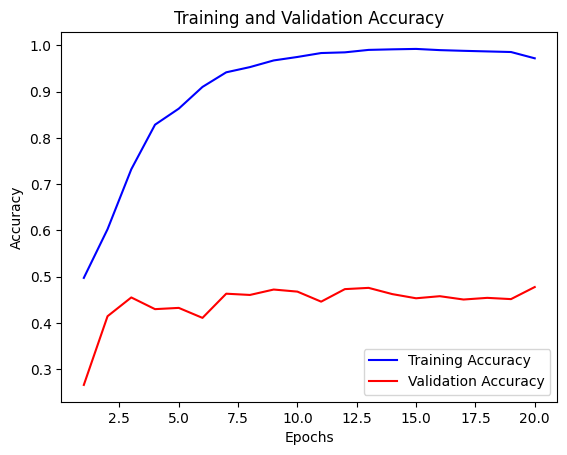

In [ ]:
epochs = range(1, 20+1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plot for confusion matrix

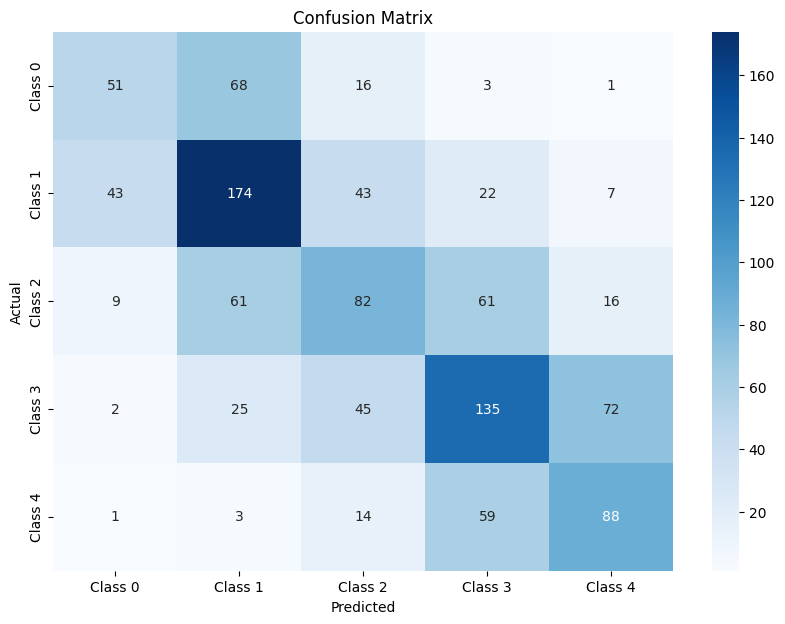

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Given confusion matrix
cm = np.array([
    [51, 68, 16, 3, 1],
    [43, 174, 43, 22, 7],
    [9, 61, 82, 61, 16],
    [2, 25, 45, 135, 72],
    [1, 3, 14, 59, 88]
])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
